In [16]:
import pandas as pd

#Work with training set manipulation
df = pd.read_csv(r"C:\Users\Vital Tavares\Documents\WPI\Machine Learning\Final Project\data_file_nocomma.csv", encoding = 'latin-1')
df.head()

,id,cuisine,ingredients
0,10259,greek,romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,plain flour ground pepper salt tomatoes ground...
2,20130,filipino,eggs pepper salt mayonaise cooking oil green c...
3,22213,indian,water vegetable oil wheat salt
4,13162,indian,black pepper shallots cornflour cayenne pepper...


In [17]:
#Analyze non-null values
df = df[pd.notnull(df['ingredients'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 0 to 39773
Data columns (total 3 columns):
id             39774 non-null int64
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [18]:
#We won't need the ID to train the data set
col = ['cuisine', 'ingredients']
df = df[col]
df.columns

Index(['cuisine', 'ingredients'], dtype='object')

In [31]:
#Transform all cuisines into a 1d array with labels
df.columns = ['cuisine', 'ingredients']
df['category_id'] = df['cuisine'].factorize()[0]
df['category_id']

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [32]:
#Testing set manipulation
test_file = pd.read_csv(r"C:\Users\Vital Tavares\Documents\WPI\Machine Learning\Final Project\test_file.csv", encoding = 'latin-1')
test_file.head()

,id,ingredients
0,18009,baking powder eggs all-purpose flour raisins m...
1,28583,sugar egg yolks corn starch cream of tartar ba...
2,41580,sausage links fennel bulb fronds olive oil cub...
3,29752,meat cuts file powder smoked sausage okra shri...
4,35687,ground black pepper salt sausage casings leeks...


In [33]:
#save Id to hstack later
test_id = test_file['id']

#Do the same data manipulation used for training
#Note it won't have cuisine since this is what we're trying to predict
test_file = test_file['ingredients']

In [28]:
#Drop duplicate categories
#Turn into dictionaries
from io import StringIO
category_id_df = df[['cuisine', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'cuisine']].values)

{'greek': 0, 'southern_us': 1, 'filipino': 2, 'indian': 3, 'jamaican': 4, 'spanish': 5, 'italian': 6, 'mexican': 7, 'chinese': 8, 'british': 9, 'thai': 10, 'vietnamese': 11, 'cajun_creole': 12, 'brazilian': 13, 'french': 14, 'japanese': 15, 'irish': 16, 'korean': 17, 'moroccan': 18, 'russian': 19}


In [24]:
df.head()

,cuisine,ingredients,category_id
0,greek,romaine lettuce black olives grape tomatoes ga...,0
1,southern_us,plain flour ground pepper salt tomatoes ground...,1
2,filipino,eggs pepper salt mayonaise cooking oil green c...,2
3,indian,water vegetable oil wheat salt,3
4,indian,black pepper shallots cornflour cayenne pepper...,3


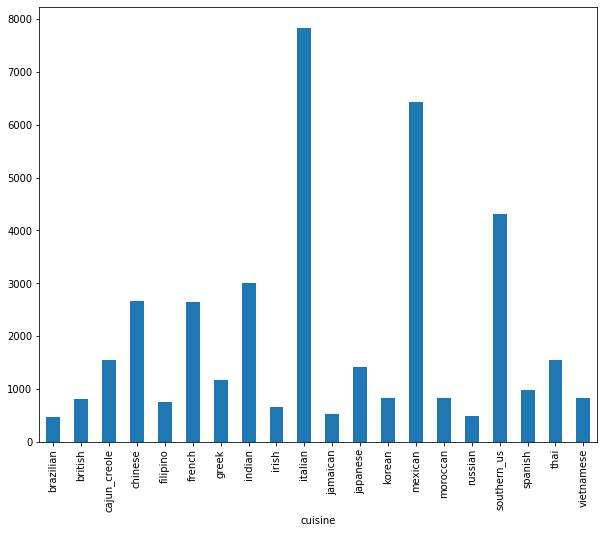

In [30]:
#Analyze the diestribution of cuisines
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
df.groupby('cuisine').ingredients.count().plot.bar(ylim=0)
plt.show()

In [10]:
#Transform the daa\ta to be used in Chi-2 test
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.ingredients).toarray()
labels = df.category_id
features.shape

(39774, 80795)

In [11]:
from sklearn.feature_selection import chi2
import numpy as np

#Return the top 3 unigrams and bigrams associated with a cuisine
N = 3
for cuisine, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(cuisine))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

MemoryError: 

In [12]:
#Before checking the test set, split the training set to see if program actually works
#Try to do a prediction using Multinomial Naive Bayes method
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['ingredients'], df['cuisine'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [14]:
#Try this Indian Recipe
print(clf.predict(count_vect.transform(['chicken thighs plain yogurt ginger garlic garam masala turmeric cumin salt canola oil coriander tomato puree ground red pepper heavy cream brown suar water cilantro'])))

['indian']


In [17]:
#Compare the MultinomialNB accuracy with Linear SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    LinearSVC(),
    MultinomialNB(),
]


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').accuracy.mean()

len models:  4


MemoryError: 

In [18]:
#Linear SVC performed before, thats what we'll use from now on
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MemoryError: 

In [ ]:
#Display confusion matrix in a heatmap
#Cool visualization
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.cuisine.values, yticklabels=category_id_df.cuisine.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#optional to run this
#Will print all the misclassifications
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['cuisine', 'ingredient']])
            print('')

In [ ]:
#We perform a Chi-2 test again to see any difference
model.fit(features, labels)
N = 3
for cuisine, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(cuisine))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
#Cool table showing the accuracy per cuisine and general accuracy
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['cuisine'].unique()))